In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scprep
import hickle as hkl

In [3]:
data_path = '../data_in_vivo'
data_ptl = np.load(f'{data_path}/primary_csc_to_lung_noncsc.npz')
data_ptp = np.load(f'{data_path}/primary_csc_to_primary_noncsc.npz')
data_combined = np.load(f'{data_path}/combined_pc_2_timepoints.npz')

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/mioflow/lib/python3.10/site-packages/scprep/plot/utils.py:99: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/mioflow/lib/python3.10/site-packages/scprep/plot/utils.py:99: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


<Axes3D: >

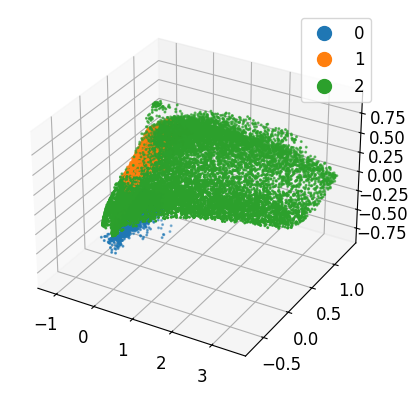

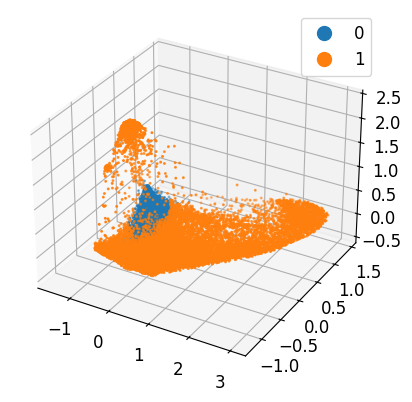

In [4]:
scprep.plot.scatter3d(data_ptl['pca'], c=data_ptl['sample_labels'])
scprep.plot.scatter3d(data_ptp['pca'], c=data_ptp['sample_labels'])

In [11]:
mioflow_df_ptl = pd.DataFrame(data_ptl['pca'][:,:5], columns=[f'd{i}' for i in range(1, 5+1)])
mioflow_df_ptl['samples'] = data_ptl['sample_labels']
mioflow_df_ptl.to_csv(f'{data_path}/mioflow_df_ptl.csv', index=False)

# mioflow_df_ptp = pd.DataFrame(data_ptp['pca'][:,:5], columns=[f'd{i}' for i in range(1, 5+1)])
# mioflow_df_ptp['samples'] = data_ptp['sample_labels']
# mioflow_df_ptp.to_csv(f'{data_path}/mioflow_df_ptp.csv', index=False)

In [14]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

pca_array = data_ptp['pca']

# Create an empty AnnData object
# n_cells = number of cells/samples in your PCA data
# We'll create a dummy gene expression matrix with all zeros
n_cells = pca_array.shape[0]
n_dummy_genes = 1  # We just need a placeholder

# Create a sparse matrix of zeros as placeholder for expression data
dummy_expression = csr_matrix((n_cells, n_dummy_genes))

# Create AnnData object
adata = sc.AnnData(X=dummy_expression)

# Add the PCA coordinates to obsm
adata.obsm['X_pca'] = pca_array

# Compute neighborhood graph directly from PCA
sc.pp.neighbors(adata, use_rep='X_pca')

In [ ]:
adata.obs['sample_labels'] = data_ptp['sample_labels']


In [18]:
# Find cells with sample_label == 0
cells_with_label_0 = np.where(adata.obs['sample_labels'] == 0)[0]

# Calculate sum of top 3 PC components for these cells
pc_sums = np.sum(adata.obsm['X_pca'][cells_with_label_0, :3], axis=1)

# Find the cell with the smallest sum
min_sum_idx = np.argmin(pc_sums)
root_cell_index = cells_with_label_0[min_sum_idx]

Selected root cell index: 20066


In [19]:
adata.uns['iroot'] = root_cell_index

# Run diffusion pseudotime
sc.tl.dpt(adata)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/mioflow/lib/python3.10/site-packages/scprep/plot/utils.py:99: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


<Axes3D: >

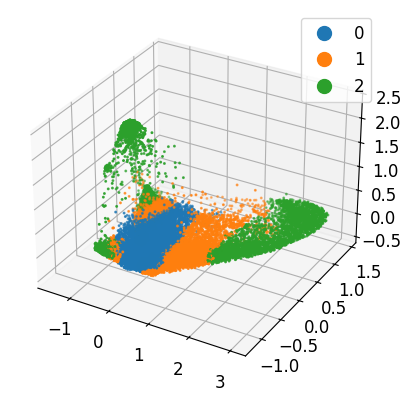

In [24]:
# Create bins with equal number of cells (quantiles) instead of equal bin width
adata.obs['dpt_bin'] = pd.qcut(adata.obs['dpt_pseudotime'], q=3, labels=False)
scprep.plot.scatter3d(adata.obsm['X_pca'], c=adata.obs['dpt_bin'])

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/mioflow/lib/python3.10/site-packages/scprep/plot/utils.py:99: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


<Axes3D: >

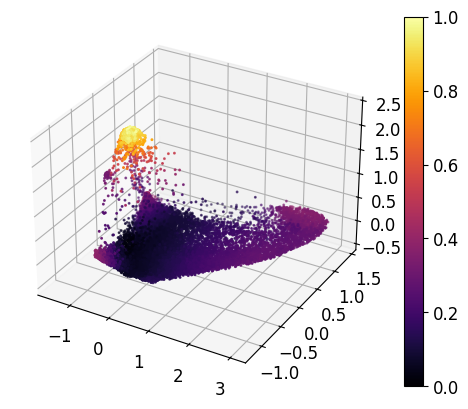

In [21]:
scprep.plot.scatter3d(adata.obsm['X_pca'], c=adata.obs['dpt_pseudotime'])

In [25]:
from plotly3d.plot import scatter

In [28]:
scatter(adata.obsm['X_pca'][:,:3], adata.obs['dpt_bin'])

In [33]:
mioflow_df_ptp = pd.DataFrame(data_ptp['pca'][:,:5], columns=[f'd{i}' for i in range(1, 5+1)])
mioflow_df_ptp['samples'] = adata.obs['dpt_bin'].values
mioflow_df_ptp.to_csv(f'{data_path}/mioflow_df_ptp.csv', index=False)